In [1]:
#########################################################################
## COMPROBAR GPU ASIGNADA EN COLABORATORY
#########################################################################
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jun 29 17:31:28 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.52.04              Driver Version: 555.52.04      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   54C    P0             26W /  100W |      15MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#########################################################################
## LIBRERIAS NECESARIAS
#########################################################################
import tensorflow as tf
import gymnasium as gym
from stable_baselines3 import PPO
from tensorflow.keras.layers import concatenate
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras import layers
import copy
from sklearn.model_selection import train_test_split

import os
from stable_baselines3.common.vec_env import DummyVecEnv

2024-06-29 17:31:28.980814: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-06-29 17:31:32.016322: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-06-29 17:31:32.016442: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-06-29 17:31:32.059682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-29 17:31:32.061445: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 Laptop GPU computeCapability: 8.6
coreClock: 1.605GHz coreCount: 30 deviceMemorySize: 5.70GiB deviceMemoryBandwidth: 312.97GiB/s
2024-06-29 17:31:32.061459: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-06-29 17:31:32.078772: I tensorflow/stream_executor/

In [4]:
############################################################################
## Variables globales (hiperparámetros)
###########################################################################
EPOCHS=1
BATCH_SIZE=140

EPISODES=10
EPISODES_EVALUATE_G=50

TOTAL_TIMESTEPS_PPO_GENERATOR=40000 
LEARNING_RATE=0.001

# GYM Lunar Lander


* **Entorno**:

  Este entorno es un **problema clásico de optimización de trayectoria de un COHETE**. Según el principio del máximo de Pontryagin, es óptimo encender el motor a máxima potencia o apagarlo. Esta es la razón por la cual este entorno tiene acciones discretas: encender el motor o apagarlo.

 Existen dos versiones del entorno: discreta o continua. La plataforma de aterrizaje siempre se encuentra en las coordenadas (0,0). Las coordenadas son los primeros dos números en el vector de estado. Es posible aterrizar fuera de la plataforma de aterrizaje. El combustible es infinito, por lo que un agente puede aprender a volar y luego aterrizar en su primer intento.

* **Acciones**: tenemos cuatro acciones discretas:

  * **0**:No hacer nada
  * **1**: Encender motor de orientación izquierdo
  * **2**: Encender motor principal
  * **3**: Encender motor de orientación derecho
* **Observaciones**: es un vector de 8 dimensiones donde se almacenan las coordenadas (x,y), las velocidades lineales en x e y, su ángulo, su velocidad angular, y dos booleanos que representan si cada pata está en contacto con el suelo o no.


## Instalación de Box2D

In [5]:
!#cd pybox2d && python setup.py build && python setup.py install

In [5]:
# Definimos el entorno
env = gym.make("LunarLander-v2")

# Obtenemos el espacio de estados y acciones del entorno
ob_space=env.observation_space
ac_space=env.action_space

# Mostramos el número de acciones del entorno
print(env.action_space.n)
# Mostramos el número de observaciones del entorno
print(ob_space.shape[0])

4
8


# Discriminador

## Red neuronal del Discriminador

In [6]:
################################################################################################################################################
# Red neuronal del Discriminador
################################################################################################################################################

# Input: secuencias [s,a] reales o sintéticas, de longitud ob_space.shape[0] + ac_space.n.
# Output: probabilidad de que la secuencia sea real, valor perteneciente al intervalo [0,1]
discriminator_net=keras.Sequential(
    [
        keras.Input(shape=(None, ob_space.shape[0] + ac_space.n )),
        layers.Dense(units=10,activation=tf.nn.relu, name='layer1'),
        layers.Dense(units=10,activation=tf.nn.relu, name='layer2'),
        layers.Dense(units=10, activation=tf.nn.relu, name='layer3'),
        layers.Dense(units=1, activation=tf.sigmoid, name='prob'),

    ],
    name="discriminator_net"

)
discriminator_net.summary()

Model: "discriminator_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, None, 10)          130       
_________________________________________________________________
layer2 (Dense)               (None, None, 10)          110       
_________________________________________________________________
layer3 (Dense)               (None, None, 10)          110       
_________________________________________________________________
prob (Dense)                 (None, None, 1)           11        
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


2024-06-29 17:31:40.579195: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-29 17:31:40.580230: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-06-29 17:31:40.580424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-29 17:31:40.584420: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 Laptop GPU computeCapability: 8.6
coreClock: 1.605GHz coreCount: 30 deviceMemorySize: 5.70GiB deviceMemoryBandwid

## Función de pérdida del Discriminador

In [7]:
#########################################################################################################
# Función de pérdida del Discriminador
#########################################################################################################

# prob1=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia REAL [s,a] de la base de datos
# prob2=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia FALSA [s,a]
def loss_fn_D(prob1, prob2):

    # Esperanza del logaritmo de la D(x)=salida de la red neuronal cuando x=entrada REAL
    loss_expert = tf.reduce_mean(tf.math.log(tf.clip_by_value(prob1, 0.01, 1)))

    # Esperanza del logaritmo de 1-D(x) donde D(x)=salida de la red neuronal cuando x=entrada FALSA
    loss_agent = tf.reduce_mean(tf.math.log(tf.clip_by_value(1 - prob2, 0.01,1)))

    loss_expert = tf.cast(loss_expert, dtype=tf.float32)
    loss_agent = tf.cast(loss_agent, dtype=tf.float32)

    loss = loss_expert + loss_agent

    loss = -loss

    return loss

## Clase del Discriminador

In [8]:
# Clase DISCRIMINADOR
class Discriminator:
    def __init__(self, env, discriminator_net, expert_s, expert_a, agent_s, agent_a):
        # -Red neuronal del Discriminador
        self.discriminator_net=discriminator_net
        # -Experto: [s,a]
        self.expert_s=expert_s
        self.expert_a=expert_a
        expert_a_one_hot=tf.one_hot(self.expert_a,depth=env.action_space.n)
        # Añadimos ruido para estabilizar el entrenamiento
        expert_a_one_hot+= tf.random.normal(tf.shape(expert_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        self.expert_s_a=tf.concat([self.expert_s,expert_a_one_hot],axis=1)

        # -Agente:  [s,a]
        self.agent_s=agent_s
        self.agent_a=agent_a
        agent_a_one_hot=tf.one_hot(self.agent_a,depth=env.action_space.n)
        agent_a_one_hot+= tf.random.normal(tf.shape(agent_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        self.agent_s_a=tf.concat([self.agent_s,agent_a_one_hot],axis=1)



        # Calculamos la salida de la red para [s,a] del experto y del agente ya que lo necesitamos para reward

        # -Salida de la red neuronal Discriminador para [s,a] expertos(verdaderos)
        self.prob_expert=self.discriminator_net(self.expert_s_a)

        # -Salida  de la red neuronal Discrimiinador para [s,a] Agente(falsos)
        self.prob_agent=self.discriminator_net(self.agent_s_a)

        #-Recompensa obtenida cuando el Agente realiza [s,a] falsas
        self.rewards=tf.math.log(tf.clip_by_value(self.prob_agent,1e-10,1)) #log(P(expert|s,a)) cuando mas grande es mejor el agente


    def getNet(self):
        return self.discriminator_net

    def getAgent_S_A(self):
        return self.agent_s_a

    def getExpert_S_A(self):
        return self.expert_s_a

    def getProb(self):
        return self.prob_expert, self.prob_agent

    def getRewards(self):
        return self.rewards

# Generador

## Redes neuronales del Generador

In [10]:
import keras

In [9]:
#####################################################################################################
# Red neuronal del Generador donde se producen acciones
####################################################################################################

# Input: estados, listas de tamaño 8, s=[s1,s2,s3,s4,...,s8]
# Output: acciones, listas de tamaño 4, a=[a1,a2,a3,a4]
generator_net_Act = keras.Sequential(
    [
        keras.Input(shape=(None, ob_space.shape[0])),
        layers.Dense(units=6, activation="sigmoid",name='layer1'),
        layers.Dense(units=6, activation="sigmoid", name='layer2'),
        layers.Dense(units=4, activation="sigmoid", name='layer3'),
        layers.Dense(units=ac_space.n, activation=tf.nn.softmax, name='layer4')

    ],
    name="generator_net_Act"
)

generator_net_Act.summary()

Model: "generator_net_Act"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, None, 6)           54        
_________________________________________________________________
layer2 (Dense)               (None, None, 6)           42        
_________________________________________________________________
layer3 (Dense)               (None, None, 4)           28        
_________________________________________________________________
layer4 (Dense)               (None, None, 4)           20        
Total params: 144
Trainable params: 144
Non-trainable params: 0
_________________________________________________________________


In [10]:
#############################################################################################################
# Red neuronal del Generador donde se producen v_pred
#############################################################################################################

# Input: estados, listas de tamaño 8, s=[s1,s2,s3,..,s8]
# Output: v_pred, listas de tamaño 1, v_pred

generator_net_v_preds=keras.Sequential(
    [
            keras.Input(shape=(None, ob_space.shape[0])),
            layers.Dense(units=6, activation="sigmoid",name='layer1'),
            layers.Dense(units=6, activation="sigmoid", name='layer2'),
            layers.Dense(units=1, activation=None, name='layer3'),
        ],
    name="generator_v_preds"
)

generator_net_v_preds.summary()

Model: "generator_v_preds"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, None, 6)           54        
_________________________________________________________________
layer2 (Dense)               (None, None, 6)           42        
_________________________________________________________________
layer3 (Dense)               (None, None, 1)           7         
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


## Función de pérdida del Generador

In [11]:
##################################################################################################################
# Función de pérdida del Generador: función objetivo de PPO "clipped surrogated"
#################################################################################################################

def loss_fn_ppo(act_probs,act_probs_old,gaes,clip_value=0.2):
    ratios = tf.exp(tf.math.log(tf.clip_by_value(act_probs, 1e-10, 1.0))
                    - tf.math.log(tf.clip_by_value(act_probs_old, 1e-10, 1.0)))

    clipped_ratios = tf.clip_by_value(ratios,clip_value_min=1 -clip_value,clip_value_max=1 +clip_value)
    loss_clip = tf.minimum( tf.multiply(gaes, ratios), tf.multiply(gaes, clipped_ratios))
    loss_clip = tf.reduce_mean(loss_clip)

    loss = -loss_clip
    tf.summary.scalar('total', loss)

    return loss

## Clase del Generador

In [12]:
#################################################################################################################
# Clase del GENERADOR: política con su optimizador PPO
################################################################################################################

# Observesé que cada generador implementa una política distinta, por tanto, se ha decidido llamar a la clase Policy_net en lugar de generator
class Policy_net:
  def __init__(self, name: str, env, obs):
        """
        env: gym env
        obs:
        """
        # -Entorno
        self.env=env

        env.reset()

        # -Modelo PPO: algoritmo de Optimización de Política Proximal
        self.model=PPO(policy="MlpPolicy", env=env, verbose=0)


        self.model.learn(total_timesteps=TOTAL_TIMESTEPS_PPO_GENERATOR)

        # -Observación inicial a partir de la cual se crean las acciones iniciales haciendo uso de las redes neuronales del generador
        self.obs=np.reshape(np.array(obs),(1,ob_space.shape[0])) 
        
        # Utilizamos las dos redes neuronales que hemos creado : generator_net_Act y generator_net_v_preds
        # V_pred=>recompensa media de que un agente ejecute una acción

        # -Acción inicial generada con red neuronal y v_pred con red neuronal
        self.act_probs =generator_net_Act(self.obs)
        
        self.v_preds = generator_net_v_preds(self.obs)

        # -Accion estocástica inicial
        self.act_stochastic = tf.random.categorical(tf.math.log(self.act_probs), num_samples=1)

        # -Acción determinística inicial
        self.act_deterministic = tf.argmax(self.act_probs, axis=1)



  # Para cada estado obs me dice la acción que el agente va a ejecutar sobre el entorno junto con v_pred
  # La elección de la acción puede ser estocástica o determinística
  def act(self, stochastic=True):
      if stochastic:
          return self.act_stochastic, self.v_preds
      else:
          return self.act_deterministic, self.v_preds

  def get_action_prob(self):
      return self.act_probs

  def get_v_preds(self):
      return self.v_preds

  def get_obs(self):
      return self.obs

  def get_model(self):
      return self.model

  def get_trainable_variables(self):
      return self.model.get_parameters()

  # Generar [s,a] falsos
  def generate_fakes(self):

      ob_space = env.observation_space
      reward = 0
      success_num = 0


      # Por cada episodio
      for iteration in range(EPISODES):
          # Inicializo todas las variables
          observations = []
          actions = []
          rewards = []
          run_policy_steps = 0

          truncated=False
          terminated=False


          #La primera acción de cada episodio se crea con la red neuronal

          obs,_=env.reset()

          Old_Policy = Policy_net('old_policy', env, obs=obs)

          act, v_pred = Old_Policy.act(stochastic=True)

          #Convertir de tensor a array
          if type(act)=='Tensor':
              # Crear una sesión de TensorFlow
              sess = tf.compat.v1.Session()

              # Evaluar el tensor dentro de la sesión y obtener el resultado como un objeto NumPy ndarray
              act = sess.run(act)

              # Cerrar la sesión
              sess.close()

          if isinstance(act, tf.Tensor):
              act=act.numpy()

          elif isinstance(act, np.ndarray):
              act=act


          action=int(act)

          next_obs,reward,terminated,truncated, info=env.step(action)

          # --Actualización de variables: ojo no introduzco el estado y accion inicial, solo introduzco los de PPO
          observations.append(next_obs)  # S_0

          Policy = Policy_net('policy',env, obs=[next_obs]) # tenemos una política entrenada

          # Por cada steps en cada episodio, mientras no se llegue a un estado terminal o un estado malo
          while terminated!= True and truncated!= True:
              # --Aumentar el numero de steps
              run_policy_steps += 1

              # --Política para ver la acción asociada al estado
              # Las observaciones son un de la forma [[s_0,s_1,s_2,s_3]] por eso su tamaño es (1,4)
              action, states_oc = Policy.get_model().predict(next_obs)

              action=int(action)

              # --Muevo al Agente al siguiente estado
              next_obs,reward,terminated,truncated,info=env.step(action)

              # --Actualización de variables
              actions.append(action) # A_i-1
              rewards.append(reward) # R_i-1

              # --Si llegamos a un estado final, el juego ha finalizado!!!
              # --Se configura el tablero de nuevo
              if terminated== True or truncated==True:
                  obs = env.reset()
                  reward = -1
                  break
              else:
                  observations.append(next_obs) # O_i
                  self.obs = next_obs

          # Ver si el episodio ha obtendo una recompensa total igual o superior a 195
          if sum(rewards) >= 195:
              success_num += 1
              if success_num >= 100:
                  break
          else:
              success_num = 0


      observations = np.reshape(observations, newshape=[-1] + list(ob_space.shape))
      actions = np.array(actions).astype(dtype=np.int32)


      return observations, actions, rewards, Old_Policy, Policy

In [13]:
##########################################################################################################
# Clase PPOTrain
##########################################################################################################
# Tenemos dos politica theta_i y theta_i+1
# Almacenamos dos políticas Policy_net(cada una de ella con su PPO) y calculamos el valor gaes a partir de valores gamma, clip_value, c_1, c_2
# Realizamos aqui el entrenamiento, cálculo de gradiente y función de pérdida del PPO para después usarlo en el generador de la GAN

class PPOTrain:

    def __init__(self, Policy, Old_Policy, obs, actions, rewards, gamma=0.95, clip_value=0.2, c_1=1, c_2=0.01):
        """
        arg:
            Policy
            Old_Policy
            gamma
            clip_value
            c_1 parámetro para la diferencia de valores
            c_2 parámetro para el bonus de entropía
        """
        self.Policy = Policy
        self.Old_Policy = Old_Policy
        self.gamma = gamma
        self.obs=obs

        self.pi_trainable = self.Policy.get_trainable_variables()
        self.old_pi_trainable = self.Old_Policy.get_trainable_variables()


        policy_name = "policy"
        old_policy_name="policy"

        policy_dict_ = self.pi_trainable[policy_name]
        old_policy_dict_=self.old_pi_trainable[old_policy_name]

        self.pi=[]
        if policy_name in self.pi_trainable and old_policy_name in self.old_pi_trainable:
            for param_name, param_value in policy_dict_.items():
                # Elimino los pesos que hay en old_policy
                del old_policy_dict_[param_name]
                # Introduzco los pesos de old_policy en policy
                old_policy_dict_[param_name] = param_value
                self.pi.append(param_value)
        else:
            print(f"No se encontró la política con el nombre: {policy_name}")


        # Le asignamos old_pi_trainable=pi_trainable ya que ajustaremos unos nuevos pi_trainable


        self.actions = actions
        self.rewards=rewards
        self.v_preds=self.Old_Policy.get_v_preds()
        self.v_preds_next=self.Policy.get_v_preds()

        #  generative advantage estimator(lambda = 1), ver ppo paper eq(11)
        self.gaes =self.get_gaes(self.rewards, self.v_preds, self.v_preds_next)

        act_probs =self.Policy.get_action_prob()
        act_probs_old =self.Old_Policy.get_action_prob()

        # la probabilidad de las acciones del agente cuando toma la actual política
        act_probs = act_probs * tf.one_hot(indices=self.actions, depth=act_probs.shape[1])
        self.act_probs = tf.reduce_sum(act_probs, axis=1)

        # la probabilidad de las acciones del agente cuando toma la antigua política
        act_probs_old = act_probs_old * tf.one_hot(indices=self.actions, depth=act_probs_old.shape[1])
        self.act_probs_old = tf.reduce_sum(act_probs_old, axis=1)

        self.loss=loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

        self.optimizer =tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

    def loss_fn_G(self):
        return loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

    def get_pi_trainable(self):
        return self.pi

    def get_optimizer(self):
        return self.optimizer

    def get_OldPolicy(self):
        return self.Old_Policy

    def get_Policy(self):
        return self.Policy

    def get_gaes(self, rewards, v_preds, v_preds_next):
        deltas = [r_t + self.gamma * v_next - v for r_t, v_next, v in zip(rewards, v_preds_next, v_preds)]
        # calcular la estimación generative advantage (lambda = 1), ver ppo paper eq(11)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(gaes) - 1)):  # es T-1, donde T es timestep con el que se ejecuta la política
            gaes[t] = gaes[t] + self.gamma * gaes[t + 1]
        return gaes

# GAIL

In [14]:
####################################################################################################################
# CLASE GAIL
####################################################################################################################
class GAN(keras.Model):
    # Constructor
    def __init__(self, discriminator, generator):
        super().__init__()
        self.discriminator = discriminator
        self.generator=generator
        self.i=0
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    # Compila el modelo GAN inicializando los optimizadores y la función de pérdida del modelo GAN
    def compile(self,d_optimizer, loss_fn_D ):
        super(GAN, self).compile(run_eagerly=True)
        self.d_optimizer = d_optimizer
        self.loss_fn_D=  loss_fn_D

    # Devuelve las métricas obtenidas con el generador y discriminador
    @property
    def metrics(self):
        return [self.d_loss_metric,self.g_loss_metric]

    # Evaluación del Discriminador
    def evaluate_D(self, X_test):
        len_real = X_test.shape[0]

        generate_observations, generate_actions, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        dataset_gen=np.concatenate([generate_observations,generate_a_one_hot],axis=1)


        len_fakes=dataset_gen.shape[0]

        # Compilamos el discriminador como CNN
        self.discriminator.discriminator_net.compile(optimizer=self.d_optimizer, loss=self.loss_fn_D, metrics=['accuracy'])

        # Evaluamos como CNN
        loss_real, acc_real=self.discriminator.discriminator_net.evaluate(X_test, tf.ones((len_real,1)), batch_size=len_real, verbose=1)

        loss_fake, acc_fake=self.discriminator.discriminator_net.evaluate(dataset_gen,tf.ones((len_fakes,1)), batch_size=len_fakes, verbose=1)

        print('>Loss real: ')
        print(loss_real)
        print('>Loss fake: ')
        print(loss_fake)


    # Evaluación del generador
    def evaluate_G(self):
        # Definimos el entorno
        env= gym.make('LunarLander-v2')

        # Lista donde amacenaremos la recompensa acumulada de cada episodio.
        # NUESTRO OBJETIVO: Agente aprenda a tomar las acciones que maximicen la recompensa
        rewards=[]

        # Para cada episodio, el Agente se mueve por el Entorno mediante acciones hasta llegar a un estado final
        # siguiendo la política que se ha aprendido en el entrenamiento de la GAN
        for episode in range(EPISODES_EVALUATE_G):
            truncated=False
            terminated=False
            R=0.0
            reward=0.0

            # Estado inicial del juego
            obs,_=env.reset()

            #Interactuamos con el Entorno hasta que lleguemos a un estado final
            while terminated!= True and truncated!=True:
                action, _=self.generator.get_model().predict(obs)
                obs,reward,terminated,truncated, info=env.step(int(action))

                # Incremento la recompensa del episodio i al haber ejecutado el step
                R+=reward

            rewards.append(R)

            # Vemos para el episodio, su recompensa acumulada que es lo que se trata de maximizar
            print("Episode  {} Total reward: {}".format(episode,R))

        # Cierro el entorno
        env.close()

        # Muestro las recompensas obtenidas en cada episodio
        indices = range(0, EPISODES_EVALUATE_G)
        plt.plot(indices,rewards)
        plt.show()

        return np.mean(rewards)

    def train_step(self, X_train):


        # 1) Generamos secuencias falsas [s,a]
        generate_observations, generate_actions, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        if generate_observations.shape[0] == generate_a_one_hot.shape[0]:
          dataset_gen = np.concatenate([generate_observations, generate_a_one_hot], axis=1)
        else:
          generate_a_one_hot_resized = np.resize(generate_a_one_hot, (generate_observations.shape[0],ac_space.n))
          dataset_gen = np.concatenate([generate_observations, generate_a_one_hot_resized], axis=1)

        # 2) Seleccionamos la muestra de datos generador con la que vamos a trabajar en este  batch de entrenamiento  
        random_indices = np.random.choice(len(dataset_gen), size=min(BATCH_SIZE,len(dataset_gen)), replace=False)
        dataset_gen= dataset_gen[random_indices]
        
        # 3) Obtenemos las secuencias reales [s,a] de los datos de entrenamiento y las combinamos
        combined_images = tf.concat([X_train, dataset_gen], axis=0)

        # 4) Las etiquetas de las imagenes combinadas las tenemos que crear nosotros introduciendo algo de ruido con tf.random.uniform
        labels = tf.concat([tf.ones((BATCH_SIZE, 1)), tf.zeros((BATCH_SIZE, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))


        ##############################################################################################################################################################
        # PASO 1:  ENTRENAMIENTO DEL DISCRIMINADOR
        #############################################################################################################################################################


        # Entrenamiento del discriminador con las [s,a, s', r] del agente(falsas o sintéticas) y del experto (reales) combinadas, esto es,
        # le pasamos un conjunto que tiene tanto secuencias reales como secuencias sintéticas
        with tf.GradientTape() as tape:
            predictions=np.zeros((2*BATCH_SIZE,6))
            # Predicciones obtenidas con el discriminador
            predictions = self.discriminator.discriminator_net(combined_images)
            # Valor de la función de pérdida al comparar las predicciones con las etiquetas reales
            d_loss = self.loss_fn_D(labels, predictions)

        # Calculo del gradiente y actualización del gradiente
        grads = tape.gradient(d_loss, self.discriminator.getNet().trainable_weights)

        self.d_optimizer.apply_gradients(
          zip(grads, self.discriminator.getNet().trainable_weights)
        )


        ################################################################################################################################################################
        # PASO 2: ENTRENAMIENTO DEL GENERADOR=POLÍTICA
        ###############################################################################################################################################################


        ppotrain=PPOTrain(Policy,Old_Policy,actions=generate_actions,rewards=rewards, obs=generate_observations[0])


        with tf.GradientTape() as tape:
            g_loss = ppotrain.loss_fn_G()


        g_loss = tf.cast(g_loss, dtype=tf.float32)


        ############################################################################################################################################################

        # Actualización de métricas del discriminador y generador
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        print("\n")
        print("\nd_loss=",d_loss.numpy())
        print("\ng_loss=",g_loss.numpy())


        return {"d_loss": self.d_loss_metric.result(),
                    "g_loss": self.g_loss_metric.result()}




# Experimentación de GAIL con LunarLander

## Experimento 1

In [15]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [16]:
longitud_trayectoria = np.count_nonzero(expert_num_tray == 0)
print(longitud_trayectoria)

547


In [19]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [20]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-6.5563200e-03  1.4126330e+00 -6.6409520e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.3019944e-02  1.4137701e+00 -6.5149987e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.9411182e-02  1.4143140e+00 -6.4241040e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 ...
 [-5.8399280e-01  5.7271480e-04  4.8840553e-02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-5.8357376e-01 -3.8873695e-03  6.6003695e-02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-5.8295580e-01 -8.0531975e-03  8.2983880e-02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 437
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 110


In [21]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

2024-06-27 17:15:46.562836: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


### Definición de GAIL

In [22]:
gan1=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [23]:
tf.config.run_functions_eagerly(True)
gan1.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [24]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140

history=gan1.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


/home/usuario/miniconda3/envs/luna/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
2024-06-27 17:29:39.438803: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-06-27 17:29:39.440618: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2688000000 Hz





d_loss= 2.5869877

g_loss= -1.7489645
1/4 [======>.......................] - ETA: 43:02 - d_loss: 2.5870 - g_loss: -1.7490


d_loss= 2.5900705

g_loss= 0.52555335
2/4 [==============>...............] - ETA: 24:03 - d_loss: 2.5885 - g_loss: -0.6117


d_loss= 2.5642223

g_loss= 3.6435153
3/4 [=====================>........] - ETA: 11:28 - d_loss: 2.5804 - g_loss: 0.8067 


d_loss= 2.607141

g_loss= 1.4808834
4/4 [==============================] - 2900s 680s/step - d_loss: 2.5871 - g_loss: 0.9752


### Evaluación de GAIL

In [25]:
# Evaluamos el Discriminador de GAIL en el TEST
gan1.evaluate_D(X_test)


1/1 [==============================] - 0s 19ms/step - loss: 0.6708 - accuracy: 0.2793
>Loss real: 
0.6473046541213989
>Loss fake: 
0.6707906723022461


Episode  0 Total reward: -303.03492990060806
Episode  1 Total reward: -168.20274883198556
Episode  2 Total reward: -179.3666313009898
Episode  3 Total reward: -46.50638557855475
Episode  4 Total reward: 7.513713376916925
Episode  5 Total reward: -136.86628345513495
Episode  6 Total reward: 92.63721737952575
Episode  7 Total reward: 11.082990495718747
Episode  8 Total reward: 0.15854956393062025
Episode  9 Total reward: -18.34278456052779
Episode  10 Total reward: -212.06455805202245
Episode  11 Total reward: -235.99362173925113
Episode  12 Total reward: -263.2170792909418
Episode  13 Total reward: -52.540531212556544
Episode  14 Total reward: -123.84125642845201
Episode  15 Total reward: -57.73309316897304
Episode  16 Total reward: -105.81570415275837
Episode  17 Total reward: -33.771759619632746
Episode  18 Total reward: 8.498855578062333
Episode  19 Total reward: -4.260664747044885
Episode  20 Total reward: -227.2405688395984
Episode  21 Total reward: -68.5609425619273
Episode  22 To

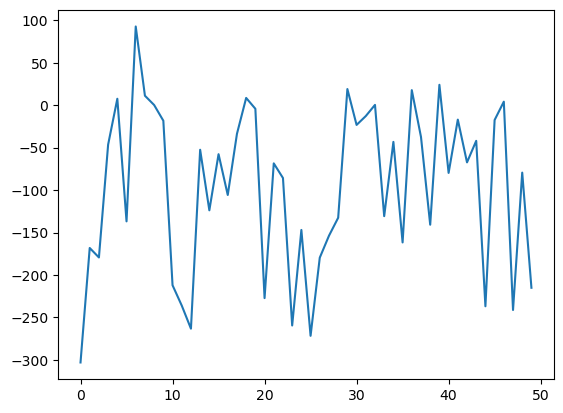


Recompensa de Media: -96.57827728546286 



In [26]:
# Evaluamos al Generador 
rewardMean=gan1.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 2

In [27]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [17]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 1)
print(longitud_trayectoria)

1127


In [29]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [30]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-6.5563200e-03  1.4126330e+00 -6.6409520e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.3019944e-02  1.4137701e+00 -6.5149987e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.9411182e-02  1.4143140e+00 -6.4241040e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 ...
 [ 5.7585880e-01 -1.8368971e-01 -2.2056554e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 5.7585880e-01 -1.8368971e-01 -3.6117143e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 5.7585880e-01 -1.8368971e-01 -4.6132280e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 901
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 226


In [31]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [32]:
gan2=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [33]:
tf.config.run_functions_eagerly(True)
gan2.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [34]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140 

history=gan2.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.604107

g_loss= 1.6006018
1/7 [===>..........................] - ETA: 1:05:49 - d_loss: 2.6041 - g_loss: 1.6006


d_loss= 2.559779

g_loss= -2.7332942
2/7 [=======>......................] - ETA: 54:48 - d_loss: 2.5819 - g_loss: -0.5663 


d_loss= 2.5663247

g_loss= 1.5805186
3/7 [===========>..................] - ETA: 43:50 - d_loss: 2.5767 - g_loss: 0.1493 


d_loss= 2.5866117

g_loss= 1.9192059
4/7 [================>.............] - ETA: 32:57 - d_loss: 2.5792 - g_loss: 0.5918


d_loss= 2.5854042

g_loss= 0.6082139
5/7 [====================>.........] - ETA: 21:59 - d_loss: 2.5804 - g_loss: 0.5950


d_loss= 2.5499654

g_loss= 2.6718738
6/7 [========================>.....] - ETA: 10:59 - d_loss: 2.5754 - g_loss: 0.9412


d_loss= 2.541269

g_loss= -3.822152
7/7 [==============================] - 4616s 660s/step - d_loss: 2.5705 - g_loss: 0.2607


### Evaluación de GAIL

In [35]:
# Evaluamos el Discriminador de GAIL en el TEST
gan2.evaluate_D(X_test)


1/1 [==============================] - 0s 18ms/step - loss: 0.6427 - accuracy: 0.0460
>Loss real: 
0.6281254887580872
>Loss fake: 
0.6427103281021118


Episode  0 Total reward: -47.25210251823657
Episode  1 Total reward: -204.72213546560835
Episode  2 Total reward: 82.81588684362062
Episode  3 Total reward: -103.40654121304466
Episode  4 Total reward: 65.39174037662697
Episode  5 Total reward: -209.14573608762905
Episode  6 Total reward: -43.935913827620524
Episode  7 Total reward: 120.45478910979153
Episode  8 Total reward: -63.833853269447175
Episode  9 Total reward: -24.907417082563583
Episode  10 Total reward: -4.134985556938093
Episode  11 Total reward: 45.72158619166423
Episode  12 Total reward: -86.64157478852984
Episode  13 Total reward: -66.5651842822478
Episode  14 Total reward: -115.23042087964134
Episode  15 Total reward: 33.539963352721884
Episode  16 Total reward: -117.32464000540905
Episode  17 Total reward: -57.07664935140778
Episode  18 Total reward: 9.293299678076195
Episode  19 Total reward: -98.00023557363355
Episode  20 Total reward: 55.49245671494538
Episode  21 Total reward: 103.13735933320339
Episode  22 Total 

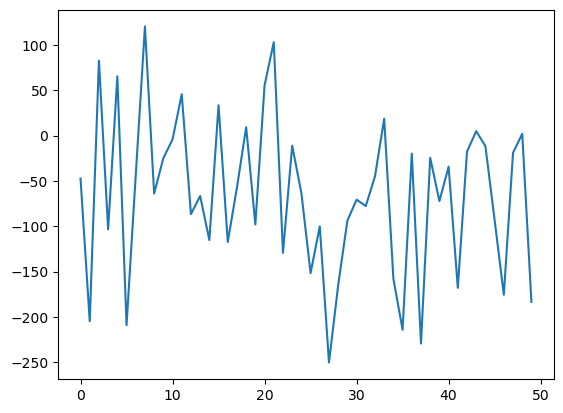


Recompensa de Media: -65.5840110086576 



In [36]:
# Evaluamos al Generador 
rewardMean=gan2.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 3

In [37]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [18]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 2)
print(longitud_trayectoria)

1572


In [39]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [40]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-0.00655632  1.412633   -0.6640952  ...  0.          0.
   1.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.          0.
   1.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.          0.
   1.        ]
 ...
 [ 0.4179185   0.11636597 -0.10107721 ...  0.          1.
   0.        ]
 [ 0.41688195  0.11385406 -0.10168035 ...  0.          1.
   0.        ]
 [ 0.41580305  0.11141074 -0.10570452 ...  0.          1.
   0.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 1257
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 315


In [41]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [42]:
gan3=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [43]:
tf.config.run_functions_eagerly(True)
gan3.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [44]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140

history=gan3.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.5267668

g_loss= -0.87284565
1/9 [==>...........................] - ETA: 1:27:38 - d_loss: 2.5268 - g_loss: -0.8728


d_loss= 2.553796

g_loss= 1.3850619
2/9 [=====>........................] - ETA: 1:16:12 - d_loss: 2.5403 - g_loss: 0.2561 


d_loss= 2.5088708

g_loss= -3.0662274
3/9 [=========>....................] - ETA: 1:05:32 - d_loss: 2.5298 - g_loss: -0.8513


d_loss= 2.5280404

g_loss= -1.6360327
4/9 [============>.................] - ETA: 54:43 - d_loss: 2.5294 - g_loss: -1.0475  


d_loss= 2.4858227

g_loss= -3.5558338
5/9 [===============>..............] - ETA: 43:47 - d_loss: 2.5207 - g_loss: -1.5492


d_loss= 2.482568

g_loss= -0.342203
6/9 [===================>..........] - ETA: 32:51 - d_loss: 2.5143 - g_loss: -1.3480


d_loss= 2.4920928

g_loss= -3.0979366
7/9 [======================>.......] - ETA: 21:55 - d_loss: 2.5111 - g_loss: -1.5980


d_loss= 2.4426517

g_loss= -2.161507
8/9 [=========================>....] - ETA: 10:58 - d_loss: 2.5026 - g_loss: -1.

### Evaluación de GAIL

In [45]:
# Evaluamos el Discriminador de GAIL en el TEST
gan3.evaluate_D(X_test)


1/1 [==============================] - 0s 17ms/step - loss: 0.6328 - accuracy: 0.0473
>Loss real: 
0.5857214331626892
>Loss fake: 
0.6327922344207764


Episode  0 Total reward: -101.52949299712319
Episode  1 Total reward: -232.4943924962734
Episode  2 Total reward: -132.50555245188207
Episode  3 Total reward: -54.30043973842365
Episode  4 Total reward: -0.5579515216308724
Episode  5 Total reward: -18.573043049059663
Episode  6 Total reward: -151.86069515279752
Episode  7 Total reward: -27.985945628395427
Episode  8 Total reward: -210.06828832648216
Episode  9 Total reward: 114.33270173525551
Episode  10 Total reward: -165.4575183218056
Episode  11 Total reward: -111.20829032146018
Episode  12 Total reward: -31.9270046747002
Episode  13 Total reward: -158.69579469168926
Episode  14 Total reward: -50.68034828520197
Episode  15 Total reward: 82.18635080632374
Episode  16 Total reward: -66.5591843755714
Episode  17 Total reward: -125.10344056239742
Episode  18 Total reward: -88.94425184853378
Episode  19 Total reward: 20.43669740667498
Episode  20 Total reward: -183.97423178289284
Episode  21 Total reward: -156.11094020797435
Episode  22 

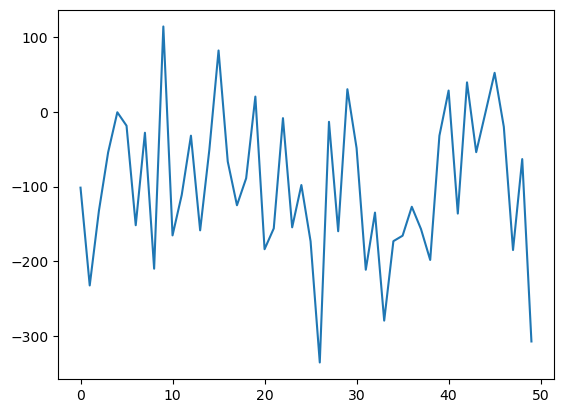


Recompensa de Media: -98.79758398966896 



In [46]:
# Evaluamos al Generador 
rewardMean=gan3.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 4

In [47]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [19]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 3)
print(longitud_trayectoria)

2168


In [49]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [50]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-6.5563200e-03  1.4126330e+00 -6.6409520e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.3019944e-02  1.4137701e+00 -6.5149987e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.9411182e-02  1.4143140e+00 -6.4241040e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 ...
 [ 4.1053313e-01  4.4803914e-02  2.5128000e-04 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [ 4.1053715e-01  4.4805490e-02  4.1009445e-04 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [ 4.1053790e-01  4.4805700e-02  7.5154120e-05 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 1734
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 434


In [51]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [52]:
gan4=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [53]:
tf.config.run_functions_eagerly(True)
gan4.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [54]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140

history=gan4.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.4952483

g_loss= 2.7643912
 1/13 [=>............................] - ETA: 2:11:27 - d_loss: 2.4952 - g_loss: 2.7644


d_loss= 2.480114

g_loss= -0.09686961
 2/13 [===>..........................] - ETA: 2:01:32 - d_loss: 2.4877 - g_loss: 1.3338


d_loss= 2.4860308

g_loss= 0.50022715
 3/13 [=====>........................] - ETA: 1:50:25 - d_loss: 2.4871 - g_loss: 1.0559


d_loss= 2.4495173

g_loss= 2.0130558
 4/13 [========>.....................] - ETA: 1:39:22 - d_loss: 2.4777 - g_loss: 1.2952


d_loss= 2.4811656

g_loss= 0.7451735
 5/13 [==========>...................] - ETA: 1:28:10 - d_loss: 2.4784 - g_loss: 1.1852


d_loss= 2.5177455

g_loss= 2.4858806
 6/13 [============>.................] - ETA: 1:17:04 - d_loss: 2.4850 - g_loss: 1.4020


d_loss= 2.46351

g_loss= 0.7520756
 7/13 [===============>..............] - ETA: 1:06:05 - d_loss: 2.4819 - g_loss: 1.3091


d_loss= 2.485539

g_loss= 0.588198
 8/13 [=================>............] - ETA: 55:07 - d_loss: 2.4824 - g_

### Evaluación de GAIL

In [55]:
# Evaluamos el Discriminador de GAIL en el TEST
gan4.evaluate_D(X_test)


1/1 [==============================] - 0s 16ms/step - loss: 0.5891 - accuracy: 0.0000e+00
>Loss real: 
0.5386828780174255
>Loss fake: 
0.5891191363334656


Episode  0 Total reward: -60.17644063138499
Episode  1 Total reward: -92.37430131610677
Episode  2 Total reward: 137.20596433921827
Episode  3 Total reward: -368.59161693154505
Episode  4 Total reward: -80.22781664705707
Episode  5 Total reward: -131.36907775462785
Episode  6 Total reward: -176.93401457397454
Episode  7 Total reward: -139.69321762552357
Episode  8 Total reward: 62.88170796161248
Episode  9 Total reward: 46.68974583684571
Episode  10 Total reward: -170.18554123195565
Episode  11 Total reward: 41.16638471316878
Episode  12 Total reward: -53.45710856305838
Episode  13 Total reward: -13.482785876203252
Episode  14 Total reward: -64.2285662227612
Episode  15 Total reward: -79.68055394337654
Episode  16 Total reward: -218.09455866603662
Episode  17 Total reward: -212.2053037416046
Episode  18 Total reward: 15.45043671977649
Episode  19 Total reward: -261.1485809599966
Episode  20 Total reward: -58.195452731223064
Episode  21 Total reward: -233.60437454648155
Episode  22 Tota

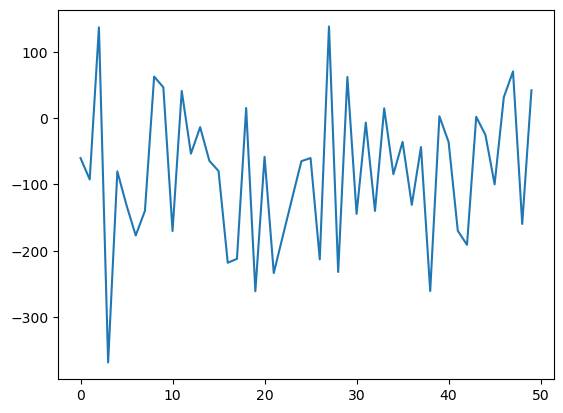


Recompensa de Media: -82.78530393905432 



In [56]:
# Evaluamos al Generador 
rewardMean=gan4.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 5

In [57]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [20]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 4)
print(longitud_trayectoria)

3158


In [59]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [60]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-6.5563200e-03  1.4126330e+00 -6.6409520e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.3019944e-02  1.4137701e+00 -6.5149987e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.9411182e-02  1.4143140e+00 -6.4241040e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 ...
 [ 6.7724630e-01  4.2385206e-02  5.4524446e-07 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 6.7724630e-01  4.2385206e-02  1.1408074e-07 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 6.7724630e-01  4.2385206e-02 -2.4774107e-07 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 2526
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 632


In [61]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [62]:
gan5=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [63]:
tf.config.run_functions_eagerly(True)
gan5.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [64]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BACH_SIZE=140

history=gan5.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.4756434

g_loss= -3.9938421
 1/19 [>.............................] - ETA: 3:19:24 - d_loss: 2.4756 - g_loss: -3.9938


d_loss= 2.4672022

g_loss= -1.1836365
 2/19 [==>...........................] - ETA: 3:08:00 - d_loss: 2.4714 - g_loss: -2.5887


d_loss= 2.474158

g_loss= -0.3007898
 3/19 [===>..........................] - ETA: 2:56:22 - d_loss: 2.4723 - g_loss: -1.8261


d_loss= 2.46319

g_loss= -1.2837243
 4/19 [=====>........................] - ETA: 2:45:34 - d_loss: 2.4700 - g_loss: -1.6905


d_loss= 2.4047008

g_loss= 3.2574632
 5/19 [======>.......................] - ETA: 2:34:32 - d_loss: 2.4570 - g_loss: -0.7009


d_loss= 2.4165006

g_loss= 0.7902651
 6/19 [========>.....................] - ETA: 2:23:12 - d_loss: 2.4502 - g_loss: -0.4524


d_loss= 2.4475524

g_loss= 1.1426138
 7/19 [==========>...................] - ETA: 2:12:18 - d_loss: 2.4498 - g_loss: -0.2245


d_loss= 2.4990075

g_loss= 1.2678804
 8/19 [===========>..................] - ETA: 2:01:18 - d_loss:

### Evaluación de GAIL

In [65]:
# Evaluamos el Discriminador de GAIL en el TEST
gan5.evaluate_D(X_test)


1/1 [==============================] - 0s 18ms/step - loss: 0.4741 - accuracy: 0.0000e+00
>Loss real: 
0.47378724813461304
>Loss fake: 
0.47409510612487793


Episode  0 Total reward: 7.919249645857093
Episode  1 Total reward: -47.4938450040638
Episode  2 Total reward: -232.71741930510618
Episode  3 Total reward: 16.940478310752752
Episode  4 Total reward: 166.03209077524224
Episode  5 Total reward: -91.34079161461123
Episode  6 Total reward: -151.240105201667
Episode  7 Total reward: 58.05820010698422
Episode  8 Total reward: 89.56905184817974
Episode  9 Total reward: 190.85964270324934
Episode  10 Total reward: -214.77168964869725
Episode  11 Total reward: -32.43545174607007
Episode  12 Total reward: -29.249706937984
Episode  13 Total reward: 32.033387529043516
Episode  14 Total reward: -189.53531067768088
Episode  15 Total reward: -218.27550814505457
Episode  16 Total reward: -36.88209187221227
Episode  17 Total reward: -163.12773583339177
Episode  18 Total reward: -4.121424053539499
Episode  19 Total reward: 138.62001099931376
Episode  20 Total reward: 199.29703160883025
Episode  21 Total reward: 18.257182985011767
Episode  22 Total rewa

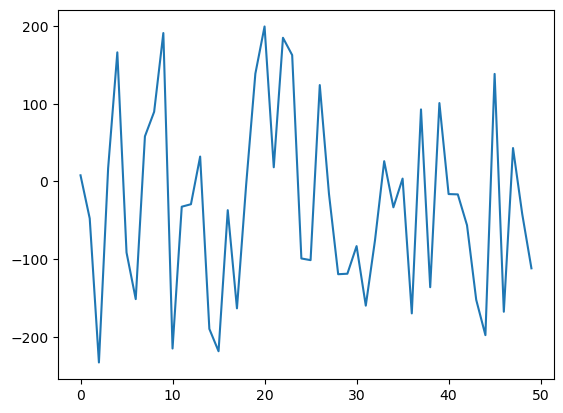


Recompensa de Media: -29.77048778932655 



In [66]:
# Evaluamos al Generador 
rewardMean=gan5.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 6

In [67]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [21]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 5)
print(longitud_trayectoria)

4158


In [69]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [70]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-6.5563200e-03  1.4126330e+00 -6.6409520e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.3019944e-02  1.4137701e+00 -6.5149987e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.9411182e-02  1.4143140e+00 -6.4241040e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 ...
 [ 3.2675964e-01 -5.1517500e-02 -1.6227339e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.2676880e-01 -5.1521648e-02  9.4594294e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.2677516e-01 -5.1524438e-02  6.5785140e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 3326
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 832


In [71]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [72]:
gan6=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [73]:
tf.config.run_functions_eagerly(True)
gan6.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [74]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140

history=gan6.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.3414257

g_loss= 0.96710724
 1/24 [>.............................] - ETA: 4:15:53 - d_loss: 2.3414 - g_loss: 0.9671


d_loss= 2.3479059

g_loss= -1.4936949
 2/24 [=>............................] - ETA: 4:02:38 - d_loss: 2.3447 - g_loss: -0.2633


d_loss= 2.3826447

g_loss= 1.0446305
 3/24 [==>...........................] - ETA: 3:52:05 - d_loss: 2.3573 - g_loss: 0.1727 


d_loss= 2.3714185

g_loss= 3.3770418
 4/24 [====>.........................] - ETA: 3:40:52 - d_loss: 2.3608 - g_loss: 0.9738


d_loss= 2.3258386

g_loss= 1.0362056
 5/24 [=====>........................] - ETA: 3:29:13 - d_loss: 2.3538 - g_loss: 0.9863


d_loss= 2.3327937

g_loss= 2.4594426
 6/24 [======>.......................] - ETA: 3:18:24 - d_loss: 2.3503 - g_loss: 1.2318


d_loss= 2.368942

g_loss= -1.1463125
 7/24 [=======>......................] - ETA: 3:07:21 - d_loss: 2.3530 - g_loss: 0.8921


d_loss= 2.3329632

g_loss= 2.8110087
 8/24 [=========>....................] - ETA: 2:56:12 - d_loss: 2.3

### Evaluación de GAIL

In [75]:
# Evaluamos el Discriminador de GAIL en el TEST
gan6.evaluate_D(X_test)


1/1 [==============================] - 0s 19ms/step - loss: 0.3245 - accuracy: 0.0000e+00
>Loss real: 
0.3653477132320404
>Loss fake: 
0.32447341084480286


Episode  0 Total reward: -34.17219786437799
Episode  1 Total reward: -111.21136760945579
Episode  2 Total reward: -148.40356410631492
Episode  3 Total reward: -175.13759623310307
Episode  4 Total reward: -29.886574104313553
Episode  5 Total reward: -63.63486504632145
Episode  6 Total reward: 49.54819546558909
Episode  7 Total reward: -18.066027715507616
Episode  8 Total reward: -11.243037938700724
Episode  9 Total reward: -86.09092443144581
Episode  10 Total reward: 41.076087776643575
Episode  11 Total reward: -491.5942740021038
Episode  12 Total reward: -180.39053690898362
Episode  13 Total reward: -198.74965365102298
Episode  14 Total reward: 24.06399390260985
Episode  15 Total reward: -55.5058455088423
Episode  16 Total reward: -153.7564036789256
Episode  17 Total reward: -49.20484354078064
Episode  18 Total reward: -6.136118106388665
Episode  19 Total reward: 44.6657662435809
Episode  20 Total reward: 12.308700287859622
Episode  21 Total reward: -69.21487559373718
Episode  22 Total

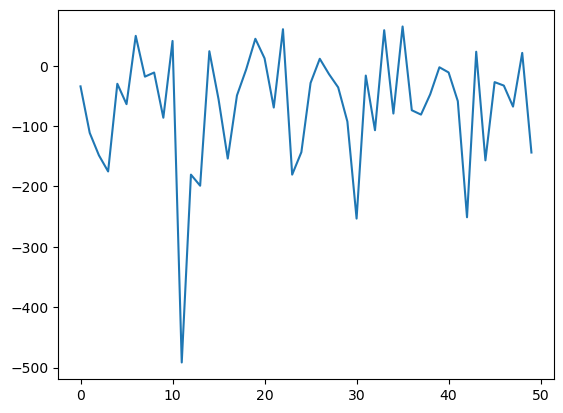


Recompensa de Media: -67.4671596553166 



In [76]:
# Evaluamos al Generador 
rewardMean=gan6.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 7

In [77]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [22]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 6)
print(longitud_trayectoria)

4680


In [22]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [23]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-6.5563200e-03  1.4126330e+00 -6.6409520e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.3019944e-02  1.4137701e+00 -6.5149987e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.9411182e-02  1.4143140e+00 -6.4241040e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 ...
 [-8.6160660e-03 -1.2264752e-03  5.3442470e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-8.6160660e-03 -1.2264752e-03  4.7162676e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-8.6160660e-03 -1.2264752e-03  3.9814470e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 3744
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 936


In [26]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [27]:
gan7=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [28]:
tf.config.run_functions_eagerly(True)
gan7.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [29]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140

history=gan7.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


/home/usuario/miniconda3/envs/luna/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
2024-06-29 08:19:45.748195: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-06-29 08:19:45.750128: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2688000000 Hz





d_loss= 2.5803287

g_loss= 6.664351
 1/27 [>.............................] - ETA: 4:31:59 - d_loss: 2.5803 - g_loss: 6.6644


d_loss= 2.5795982

g_loss= -1.1229023
 2/27 [=>............................] - ETA: 4:20:09 - d_loss: 2.5800 - g_loss: 2.7707


d_loss= 2.5189905

g_loss= 2.439081
 3/27 [==>...........................] - ETA: 4:09:08 - d_loss: 2.5596 - g_loss: 2.6602


d_loss= 2.517967

g_loss= 2.5893955
 4/27 [===>..........................] - ETA: 3:58:49 - d_loss: 2.5492 - g_loss: 2.6425


d_loss= 2.5217056

g_loss= 0.5591513
 5/27 [====>.........................] - ETA: 3:49:10 - d_loss: 2.5437 - g_loss: 2.2258


d_loss= 2.5434637

g_loss= -1.3269873
 6/27 [=====>........................] - ETA: 3:38:34 - d_loss: 2.5437 - g_loss: 1.6337


d_loss= 2.4784498

g_loss= -0.46860218
 7/27 [======>.......................] - ETA: 3:28:17 - d_loss: 2.5344 - g_loss: 1.3334


d_loss= 2.499676

g_loss= 0.4903454
 8/27 [=======>......................] - ETA: 3:17:57 - d_loss: 2.5300 

### Evaluación de GAIL

In [30]:
# Evaluamos el Discriminador de GAIL en el TEST
gan7.evaluate_D(X_test)


1/1 [==============================] - 0s 18ms/step - loss: 0.4951 - accuracy: 0.0000e+00
>Loss real: 
0.5142164826393127
>Loss fake: 
0.4951418936252594


Episode  0 Total reward: -59.558579784647584
Episode  1 Total reward: -48.69188810634171
Episode  2 Total reward: -107.29701570155612
Episode  3 Total reward: 14.279578423588205
Episode  4 Total reward: -64.44887389021288
Episode  5 Total reward: 26.31311170589126
Episode  6 Total reward: 14.341434416739148
Episode  7 Total reward: 26.685341771568332
Episode  8 Total reward: 106.59358496158131
Episode  9 Total reward: 73.88100976551529
Episode  10 Total reward: -8.96857011171833
Episode  11 Total reward: 23.897586450424726
Episode  12 Total reward: -15.092042984904282
Episode  13 Total reward: -22.872450798373734
Episode  14 Total reward: -14.912387696632791
Episode  15 Total reward: 97.69065561760516
Episode  16 Total reward: 51.1684450895748
Episode  17 Total reward: 27.05572996985795
Episode  18 Total reward: -241.3540512096171
Episode  19 Total reward: -38.43941583724592
Episode  20 Total reward: -105.48884518658728
Episode  21 Total reward: -48.55619887851347
Episode  22 Total rew

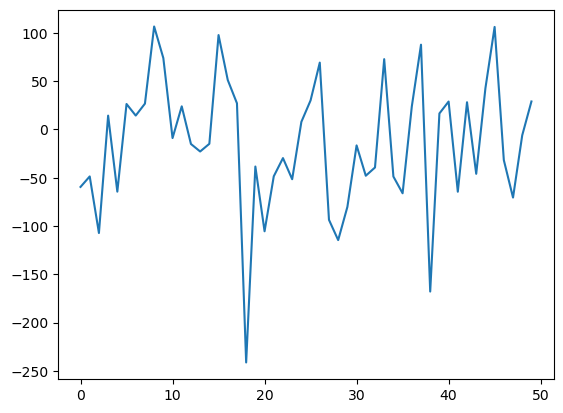


Recompensa de Media: -14.93754606290993 



In [31]:
# Evaluamos al Generador 
rewardMean=gan7.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 8

In [32]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [23]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 7)
print(longitud_trayectoria)

5314


In [24]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [25]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-6.5563200e-03  1.4126330e+00 -6.6409520e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.3019944e-02  1.4137701e+00 -6.5149987e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.9411182e-02  1.4143140e+00 -6.4241040e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 ...
 [ 1.3379402e-01  3.4672476e-03  6.3765560e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.3379402e-01  3.4672476e-03  5.2665534e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.3379402e-01  3.4672476e-03  4.0811244e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 4251
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 1063


In [26]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

2024-06-29 17:33:32.879692: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


### Definición de GAIL

In [27]:
gan8=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [28]:
tf.config.run_functions_eagerly(True)
gan8.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [29]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140

history=gan8.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


/home/usuario/miniconda3/envs/luna/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
2024-06-29 17:44:13.370486: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-06-29 17:44:13.371920: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2688000000 Hz





d_loss= 2.6422431

g_loss= -10.358641
 1/31 [..............................] - ETA: 5:10:54 - d_loss: 2.6422 - g_loss: -10.3586


d_loss= 2.6933951

g_loss= -1.2826923
 2/31 [>.............................] - ETA: 4:59:09 - d_loss: 2.6678 - g_loss: -5.8207 


d_loss= 2.6421814

g_loss= 2.876808
 3/31 [=>............................] - ETA: 4:51:42 - d_loss: 2.6593 - g_loss: -2.9215


d_loss= 2.6125145

g_loss= 0.80416924
 4/31 [==>...........................] - ETA: 4:41:08 - d_loss: 2.6476 - g_loss: -1.9901


d_loss= 2.7240653

g_loss= -2.8045654
 5/31 [===>..........................] - ETA: 4:30:09 - d_loss: 2.6629 - g_loss: -2.1530


d_loss= 2.6499934

g_loss= -3.3338046
 6/31 [====>.........................] - ETA: 4:20:13 - d_loss: 2.6607 - g_loss: -2.3498


d_loss= 2.6606765

g_loss= -0.11997473
 7/31 [=====>........................] - ETA: 4:10:01 - d_loss: 2.6607 - g_loss: -2.0312


d_loss= 2.6686459

g_loss= -3.6420572
 8/31 [======>.......................] - ETA: 3:59:53 -

### Evaluación de GAIL

In [30]:
# Evaluamos el Discriminador de GAIL en el TEST
gan8.evaluate_D(X_test)


1/1 [==============================] - 0s 17ms/step - loss: 0.6501 - accuracy: 0.0938
>Loss real: 
0.6513626575469971
>Loss fake: 
0.6501250267028809


Episode  0 Total reward: 0.35950245008660886
Episode  1 Total reward: -117.15498375926236
Episode  2 Total reward: -111.6125342735213
Episode  3 Total reward: -93.89183733851539
Episode  4 Total reward: 37.75354586788377
Episode  5 Total reward: 129.95515846617315
Episode  6 Total reward: 78.15905339710524
Episode  7 Total reward: 111.88117064759733
Episode  8 Total reward: -86.57756749968344
Episode  9 Total reward: -72.47542501961873
Episode  10 Total reward: 3.0011409239041313
Episode  11 Total reward: -7.755396297139441
Episode  12 Total reward: -92.8844661885007
Episode  13 Total reward: -85.20794681277039
Episode  14 Total reward: -71.50194600991078
Episode  15 Total reward: -103.91834672211527
Episode  16 Total reward: 73.2589944408997
Episode  17 Total reward: -80.9802119339403
Episode  18 Total reward: -38.22772249150523
Episode  19 Total reward: 40.124570872734544
Episode  20 Total reward: -43.20471245122086
Episode  21 Total reward: 118.15895940425256
Episode  22 Total rewar

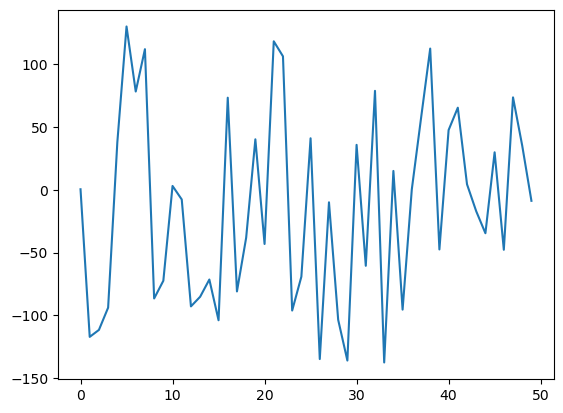


Recompensa de Media: -14.216945681889458 



In [31]:
# Evaluamos al Generador 
rewardMean=gan8.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 9

In [32]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [33]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 8)
print(longitud_trayectoria)

5799


In [34]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [35]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-0.00655632  1.412633   -0.6640952  ...  0.          0.
   1.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.          0.
   1.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.          0.
   1.        ]
 ...
 [ 0.7474047   0.0260748  -0.02635835 ...  0.          0.
   0.        ]
 [ 0.74719274  0.02124918 -0.04889769 ...  0.          0.
   1.        ]
 [ 0.74685365  0.01683348 -0.05817185 ...  0.          0.
   1.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 4639
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 1160


In [36]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [37]:
gan9=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [38]:
tf.config.run_functions_eagerly(True)
gan9.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [39]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140

history=gan9.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.5399475

g_loss= -2.078131
 1/34 [..............................] - ETA: 5:44:12 - d_loss: 2.5399 - g_loss: -2.0781


d_loss= 2.5033076

g_loss= 3.5110385
 2/34 [>.............................] - ETA: 5:31:43 - d_loss: 2.5216 - g_loss: 0.7165 


d_loss= 2.5687623

g_loss= 2.1938856
 3/34 [=>............................] - ETA: 5:22:58 - d_loss: 2.5373 - g_loss: 1.2089


d_loss= 2.547183

g_loss= -0.17129393
 4/34 [==>...........................] - ETA: 5:12:33 - d_loss: 2.5398 - g_loss: 0.8639


d_loss= 2.5547194

g_loss= 1.0558069
 5/34 [===>..........................] - ETA: 5:02:45 - d_loss: 2.5428 - g_loss: 0.9023


d_loss= 2.5306106

g_loss= 1.7895995
 6/34 [====>.........................] - ETA: 4:52:11 - d_loss: 2.5408 - g_loss: 1.0502


d_loss= 2.5331416

g_loss= -2.6238055
 7/34 [=====>........................] - ETA: 4:41:11 - d_loss: 2.5397 - g_loss: 0.5253


d_loss= 2.5100515

g_loss= -3.4521604
 8/34 [======>.......................] - ETA: 4:30:43 - d_loss: 2.

### Evaluación de GAIL

In [40]:
# Evaluamos el Discriminador de GAIL en el TEST
gan9.evaluate_D(X_test)


1/1 [==============================] - 0s 18ms/step - loss: 0.5445 - accuracy: 0.0000e+00
>Loss real: 
0.5509620308876038
>Loss fake: 
0.5445390343666077


Episode  0 Total reward: 10.489458972956129
Episode  1 Total reward: -178.21847126852538
Episode  2 Total reward: -15.963941513569395
Episode  3 Total reward: -66.65929581298602
Episode  4 Total reward: -20.71182172974666
Episode  5 Total reward: -43.985158251121526
Episode  6 Total reward: -41.140983826110684
Episode  7 Total reward: -42.732933492472156
Episode  8 Total reward: -56.45714710972885
Episode  9 Total reward: -173.9513462582605
Episode  10 Total reward: -93.56586187667082
Episode  11 Total reward: -63.15480519890768
Episode  12 Total reward: -18.51756930923746
Episode  13 Total reward: -238.48744329676768
Episode  14 Total reward: -80.94136868547209
Episode  15 Total reward: -76.05337297568633
Episode  16 Total reward: -238.8475207124862
Episode  17 Total reward: 75.1865602576378
Episode  18 Total reward: -22.45898019632466
Episode  19 Total reward: -161.4204037641074
Episode  20 Total reward: -75.05004860180824
Episode  21 Total reward: 121.02467918377864
Episode  22 Tota

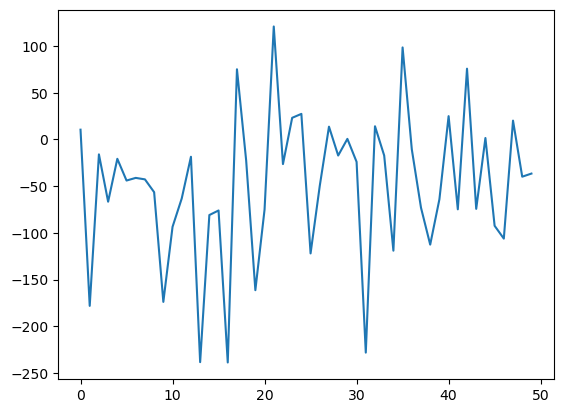


Recompensa de Media: -49.7886097291113 



In [54]:
# Evaluamos al Generador 
rewardMean=gan9.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 10

In [42]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [43]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 9)
print(longitud_trayectoria)

6310


In [44]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [45]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-0.00655632  1.412633   -0.6640952  ...  0.          0.
   1.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.          0.
   1.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.          0.
   1.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.          0.
   0.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.          0.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.          0.
   1.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 5048
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 1262


In [46]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)
BATCH_SIZE= round(len(X_train)/300)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [47]:
gan10=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [48]:
tf.config.run_functions_eagerly(True)
gan10.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [49]:
print(BATCH_SIZE)

17


In [50]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140

history=gan10.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.477433

g_loss= 4.338406
 1/37 [..............................] - ETA: 6:11:00 - d_loss: 2.4774 - g_loss: 4.3384


d_loss= 2.4704845

g_loss= 1.1143048
 2/37 [>.............................] - ETA: 6:09:58 - d_loss: 2.4740 - g_loss: 2.7264


d_loss= 2.367797

g_loss= 3.2293499
 3/37 [=>............................] - ETA: 5:56:26 - d_loss: 2.4386 - g_loss: 2.8940


d_loss= 2.4102514

g_loss= -3.1550732
 4/37 [==>...........................] - ETA: 5:45:58 - d_loss: 2.4315 - g_loss: 1.3817


d_loss= 2.4821157

g_loss= 2.3277428
 5/37 [===>..........................] - ETA: 5:35:10 - d_loss: 2.4416 - g_loss: 1.5709


d_loss= 2.4596353

g_loss= -4.2956524
 6/37 [===>..........................] - ETA: 5:23:41 - d_loss: 2.4446 - g_loss: 0.5932


d_loss= 2.4337814

g_loss= 3.0983393
 7/37 [====>.........................] - ETA: 5:12:55 - d_loss: 2.4431 - g_loss: 0.9511


d_loss= 2.4304287

g_loss= -0.25162223
 8/37 [=====>........................] - ETA: 5:02:35 - d_loss: 2.4415

### Evaluación de GAIL

In [51]:
# Evaluamos el Discriminador de GAIL en el TEST
gan10.evaluate_D(X_test)


1/1 [==============================] - 0s 16ms/step - loss: 0.3475 - accuracy: 0.0000e+00
>Loss real: 
0.41881686449050903
>Loss fake: 
0.347489595413208


Episode  0 Total reward: 20.490102709361963
Episode  1 Total reward: -12.441499127431484
Episode  2 Total reward: -70.29601486899625
Episode  3 Total reward: -88.00126074637664
Episode  4 Total reward: -32.4312060138696
Episode  5 Total reward: 3.5020590428017044
Episode  6 Total reward: -33.03013148939441
Episode  7 Total reward: -165.50237975541748
Episode  8 Total reward: -56.73392417973021
Episode  9 Total reward: -25.879085761338615
Episode  10 Total reward: -22.738408275021754
Episode  11 Total reward: -121.11346992312222
Episode  12 Total reward: -61.24045172288146
Episode  13 Total reward: -21.867909426168865
Episode  14 Total reward: -61.818500549142456
Episode  15 Total reward: -31.308366668768045
Episode  16 Total reward: -77.6780420732064
Episode  17 Total reward: -6.502080722138288
Episode  18 Total reward: -47.486088250915486
Episode  19 Total reward: -2.148282341191887
Episode  20 Total reward: -74.3285618674539
Episode  21 Total reward: 108.13404424781453
Episode  22 To

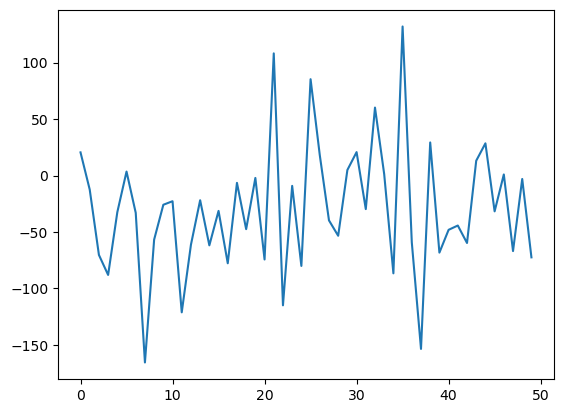


Recompensa de Media: -30.13551169600457 



In [52]:
# Evaluamos al Generador 
rewardMean=gan10.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')